# Self-Driving Engineer NanoDegree
# Project 3: Behavioral Cloning
## Author: ChangYuan Liu
### The project includes the following steps:
1. Setup simulator and model training environment in Python.
2. Collect training data in the simulator.
3. Train the deep learning model of behavioral cloning in Python.
4. Apply the trained model back in the simulator.


### Step 1: Setup simulator and Python environment
This step was done on my laptop by following the instructions:

[Self-driving-car-sim](https://github.com/udacity/self-driving-car-sim)

[CarND-Term1-Starter-Kit](https://github.com/udacity/CarND-Term1-Starter-Kit/blob/master/doc/configure_via_anaconda.md)

Both links are not up-to-date with the latest Python, tensorflow, etc. But they are still good start points.
When I was running "python drive.py model.h5" in the cmd window, it didn't connect to the simulator in Unity. The following link helps to fix the issue.
https://github.com/llSourcell/How_to_simulate_a_self_driving_car/issues/34

### Step 2: Collect training data in the simulator
Training data was collected by manually driving the car in the simulator. The simulation environment would save the data for training in the later steps.

In [1]:
## import libraries
import csv
import cv2
import numpy as np
import keras
from keras import models
import matplotlib.pyplot as plt
%matplotlib inline

## import data information from the .csv data file
lines = []
with open('./data2/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

## load the actual data/images according to the data info
images, measurements = [], []
correction = 0.2
for line in lines:
    filename = line[0]
    center_image = cv2.imread(filename)
    center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
    images.append(center_image)
    measurement = float(line[3])
    measurements.append(measurement)
    filename = line[1]
    left_image = cv2.imread(filename)
    left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
    images.append(left_image)
    measurements.append(measurement+correction)
    filename = line[2]
    right_image = cv2.imread(filename)
    right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)
    images.append(right_image)
    measurements.append(measurement-correction)    

In [2]:
## data preprocessing
# augment the data
augmented_images, augmented_measurements = [], []
for image, measurement in zip(images, measurements):
    augmented_images.append(image)
    augmented_measurements.append(measurement)
    augmented_images.append(cv2.flip(image,1))
    augmented_measurements.append(measurement*-1.0)

X_train = np.array(augmented_images)
y_train = np.array(augmented_measurements)

print(X_train.shape)
print(y_train.shape)

print(augmented_images[0].shape)

(123528, 160, 320, 3)
(123528,)
(160, 320, 3)


<class 'numpy.ndarray'>


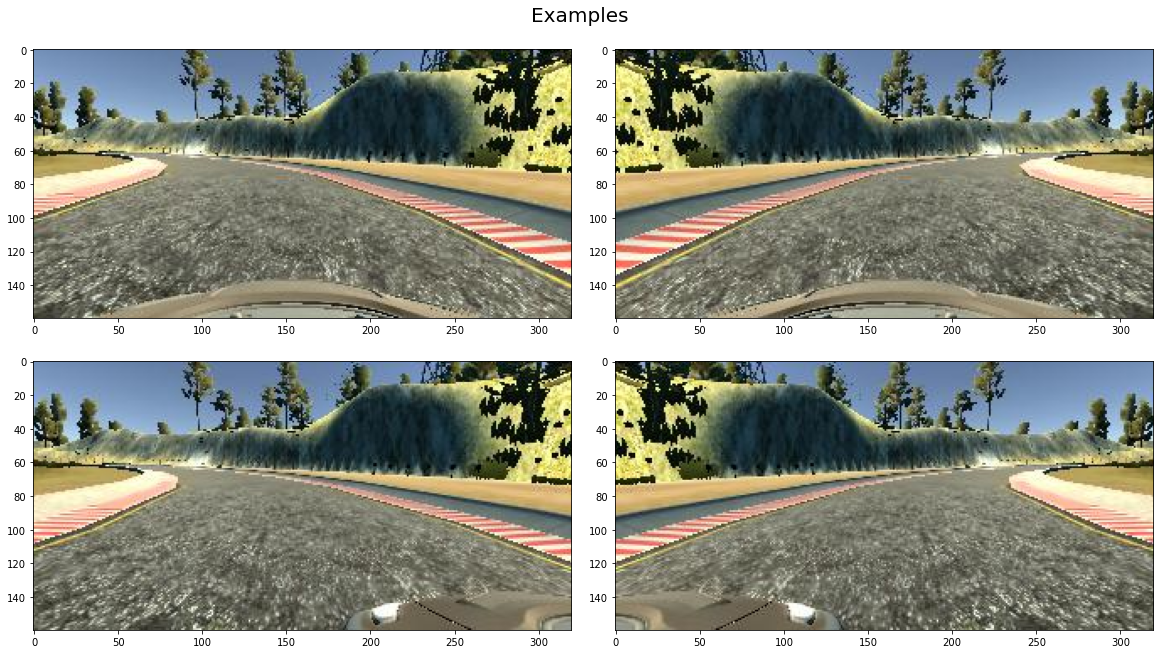

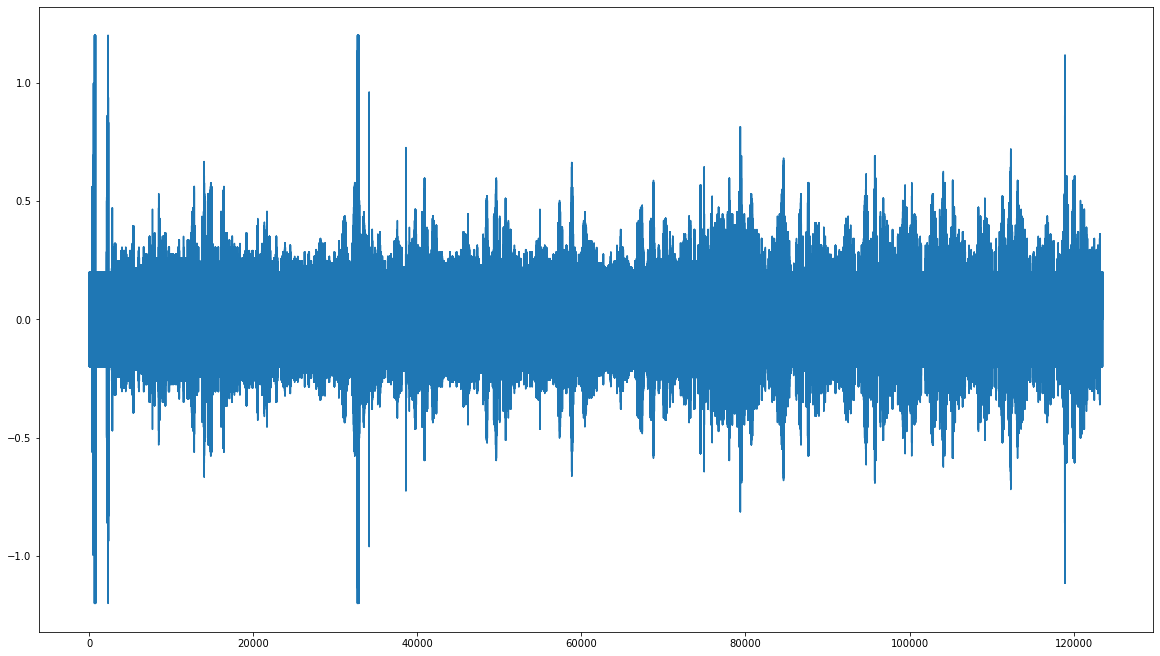

In [3]:
fig, ax = plt.subplots(2, 2, figsize=[16,9], constrained_layout=True)
print(type(ax[0]))
fig.suptitle('Examples', fontsize=20)
ax[0][0].imshow(augmented_images[0], cmap='gray')
ax[0][1].imshow(augmented_images[1])
ax[1][0].imshow(augmented_images[2])
ax[1][1].imshow(augmented_images[3])

fig, ax = plt.subplots(figsize=[16,9], constrained_layout=True)
ax.plot(y_train)

In [4]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Cropping2D, Conv2D
from keras import optimizers
import tensorflow as tf
# build the model (implement the model fron nvidia)
model = Sequential()
# lambda layer for normalization
model.add(Lambda(lambda x: (x/255.0-0.5), input_shape=(160,320,3)))
# If tuple of 2 tuples of 2 ints: interpreted as ((top_crop, bottom_crop), (left_crop, right_crop))
model.add(Cropping2D(cropping=((70,20),(0,0))))
model.add(Conv2D(filters=24, kernel_size=(5,5), strides=(2,2), activation='relu'))
model.add(Conv2D(filters=36, kernel_size=(5,5), strides=(2,2), activation='relu'))
model.add(Conv2D(filters=48, kernel_size=(5,5), strides=(2,2), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(1))

# compile the model
optimizeropts = optimizers.Adam(lr=2.0e-3)
model.compile(loss='mse', metrics=['mse'], optimizer=optimizeropts)


## Step 3: Train the deep learning model

In [5]:
# train the model
history = model.fit(X_train, y_train, validation_split=0.2, \
          shuffle=True, verbose=1 , epochs=4)

# save the model for its deployment in the "autonomous mode" in the simulator
model.save('model.h5')

Epoch 1/4
3089/3089 [==============================] - 856s 277ms/step - loss: 0.0177 - mse: 0.0177 - val_loss: 0.0085 - val_mse: 0.0085
Epoch 2/4
3089/3089 [==============================] - 855s 277ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0091 - val_mse: 0.0091
Epoch 3/4
3089/3089 [==============================] - 851s 275ms/step - loss: 0.0081 - mse: 0.0081 - val_loss: 0.0082 - val_mse: 0.0082
Epoch 4/4
3089/3089 [==============================] - 850s 275ms/step - loss: 0.0082 - mse: 0.0082 - val_loss: 0.0085 - val_mse: 0.0085


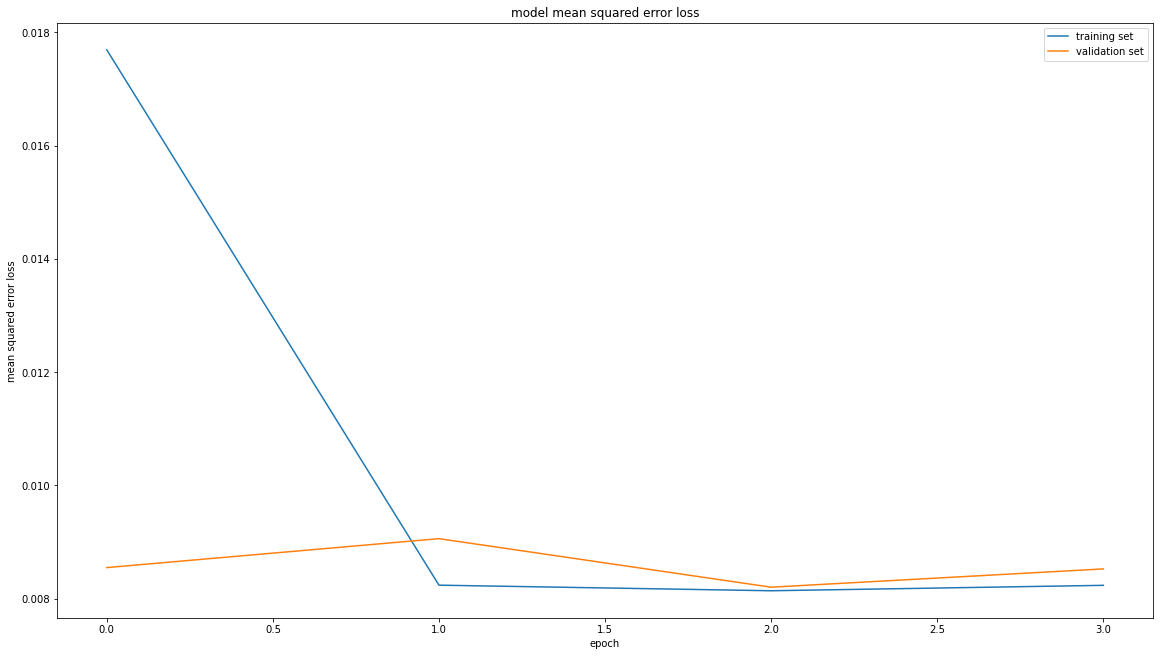

In [6]:
# Virtualize the loss in the training process
fig, ax = plt.subplots(figsize=[16,9], constrained_layout=True)
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('model mean squared error loss')
ax.set_ylabel('mean squared error loss')
ax.set_xlabel('epoch')
ax.legend(['training set', 'validation set'], loc='upper right')
plt.show()

In [7]:
# predict with all the training data and calculate mse and r2
from sklearn.metrics import mean_squared_error, r2_score
y_predict = model.predict(X_train)
mse = mean_squared_error(y_train, y_predict)
r2 = r2_score(y_train, y_predict)
print("MSE = ", mse)
print("R2 = ", r2)

MSE =  0.007492249920426675
R2 =  0.822723985215535


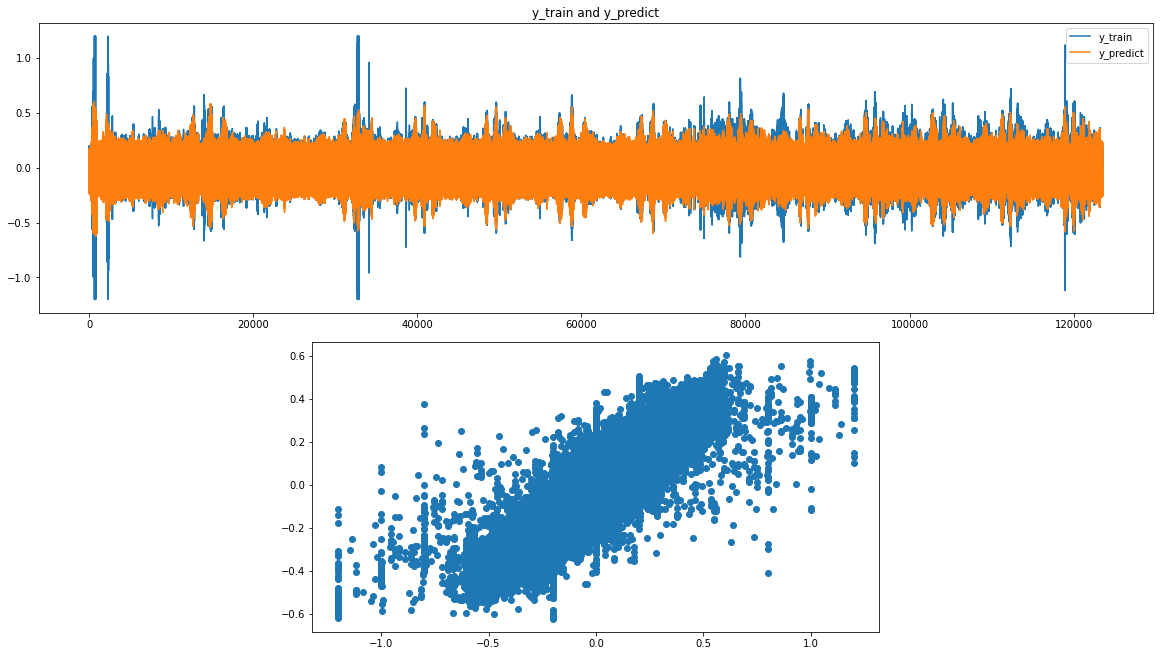

In [10]:
# plot mse and r2
fig, ax = plt.subplots(2, 1, figsize=[16,9], constrained_layout=True)
ax[0].plot(y_train)
ax[0].plot(y_predict)
ax[0].set_title('y_train and y_predict')
ax[0].legend(['y_train', 'y_predict'], loc='upper right')
ax[1].scatter(y_train, y_predict)
ax[1].set_aspect('equal')
plt.show()

## Step 4: Apply the trained model in the simulator
The last step, take the trained model (model.h5) and apply it in the simulator. 
